# Banking Deserts

In [5]:
# Dependencies
from census import Census
from config import census_key
import hvplot.pandas
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")


# Create an instance of the Census library
c = Census(census_key, year=2019)

## 1. Retrieve data from the U.S. Census using the Census Python library and the preconfigured labels

References:

* Review the following page to review the Python library documentation: <https://github.com/CommerceDataService/census-wrapper>

* Review the following page to learn more about the data labels: <https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b>

In [6]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
census_data = c.acs5.get(
    (
        "B01003_001E",
        "B17001_002E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column renaming
census_pd = census_pd.rename(
    columns = {
        "B01003_001E": "Population",
        "B17001_002E": "Poverty Count",
        "zip code tabulation area": "Zipcode"
    }
)

# Add a Poverty Rate column (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

# Configure the final DataFrame
census_pd = census_pd[
    [
        "Zipcode",
        "Population",
        "Poverty Rate"
    ]
]

# Display DataFrame length and sample data
print(f"Number of rows in the DataFrame: {len(census_pd)}")
census_pd.head()

Number of rows in the DataFrame: 33120


,Zipcode,Population,Poverty Rate
0,00601,17113.0,61.660726
1,00602,37751.0,49.410612
2,00603,47081.0,50.319662
3,00606,6392.0,65.472466
4,00610,26686.0,45.731844


## 2. Load the `zip_bank_data.csv` file into a DataFrame. Next, use Pandas to merge this data set with the Census data that you retrieved along the zip code.

In [7]:
# Import the zip bank data. Use dtype="object" to ensure all data is read in accurately.
zip_code_pd = pd.read_csv(
    "../Resources/zip_bank_data.csv",
    dtype = "object",
    encoding = "utf-8"
)

# Display sample data
zip_code_pd.head()

,Unnamed: 0,Zipcode,Address,Median Age,Household Income,Per Capita Income,Lat,Lng,Bank Count
0,0,49908,"Baraga, MI 49908",46,27030,15371,46.8359,-88.5070,5
1,1,47443,"Lyons, IN 47443",33,83212,91548,38.9565,-87.0931,8
2,2,55392,"Navarre, MN 55392",38,182718,56648,44.9434,-93.6077,81
3,3,74469,"Warner, OK 74469",43,183752,82932,35.5007,-95.3006,73
4,4,70791,"Zachary, LA 70791",43,120257,69028,30.6455,-91.1385,78


In [8]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(
    zip_code_pd,
    census_pd,
    how = "left",
    on = ["Zipcode", "Zipcode"]
)

# Remove rows with missing data
census_data_complete = census_data_complete.dropna()

# Transform latitude and longitude to float
census_data_complete["Lat"] = census_data_complete["Lat"].astype(float)
census_data_complete["Lng"] = census_data_complete["Lng"].astype(float)

# Display sample data
census_data_complete.head()

,Unnamed: 0,Zipcode,Address,Median Age,Household Income,Per Capita Income,Lat,Lng,Bank Count,Population,Poverty Rate
0,0,49908,"Baraga, MI 49908",46,27030,15371,46.8359,-88.5070,5,3376.0,12.529621
1,1,47443,"Lyons, IN 47443",33,83212,91548,38.9565,-87.0931,8,1275.0,16.392157
3,3,74469,"Warner, OK 74469",43,183752,82932,35.5007,-95.3006,73,2528.0,24.169304
4,4,70791,"Zachary, LA 70791",43,120257,69028,30.6455,-91.1385,78,27046.0,8.533609
5,5,76885,"Valley Spring, TX 76885",34,29712,11057,30.8310,-98.8289,5,216.0,4.166667


## 3. Use GeoViews to create a poverty rate map.

* Use the "Poverty Rate" column to set the point's size. Recall to use the `scale` parameter to modify the size appearance.

* Use the "Zipcode" column to set the point's colour.

* Read the HoloViews documentation and learng how you can use the `hover_cols` parameter to add additional information to the tooltip of a point. Add the "Address" and the "Bank Count" columns.

In [9]:
# Configure the map
poverty_rate_map = census_data_complete.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 600,
    size = "Poverty Rate",
    scale = 2,
    color = "Zipcode",
    hover_cols = ["Address", "Bank Count"]
)

# Display the map plot
poverty_rate_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (Zipcode,Poverty Rate,Address,Bank Count)

## 4. Compute and print the summary statistics for "Poverty Rate", "Bank Count", and "Population"

In [10]:
# Mean, median, mode for Poverty Rate
poverty_mean = round(census_data_complete["Poverty Rate"].astype("float").mean(), 2)
poverty_median = round(census_data_complete["Poverty Rate"].astype("float").median(), 2)
poverty_mode = round(census_data_complete["Poverty Rate"].astype("float").mode(), 2)

print(f"Poverty Rate Mean: {poverty_mean}")
print(f"Poverty Rate Median {poverty_median}")
print(f"Poverty Rate mode {poverty_mode}")

Poverty Rate Mean: 13.66
Poverty Rate Median 11.05
Poverty Rate mode 0    0.0
Name: Poverty Rate, dtype: float64


In [11]:
# Mean, median, mode for Bank Count
bank_mean = round(census_data_complete["Bank Count"].astype("float").mean(), 2)
bank_median = round(census_data_complete["Bank Count"].astype("float").median(), 2)
bank_mode = round(census_data_complete["Bank Count"].astype("float").mode(), 2)

print(f"Bank Count Mean: {bank_mean}")
print(f"Bank Count Median {bank_median}")
print(f"Bank Count mode {bank_mode}")

Bank Count Mean: 41.01
Bank Count Median 36.0
Bank Count mode 0    4.0
Name: Bank Count, dtype: float64


In [12]:
# Mean, median, mode for Population
population_mean = round(census_data_complete["Population"].astype("float").mean(), 2)
population_median = round(census_data_complete["Population"].astype("float").median(), 2)
population_mode = round(census_data_complete["Population"].astype("float").mode(), 2)

print(f"Population Mean: {population_mean}")
print(f"Population Median {population_median}")
print(f"Population mode {population_mode}")

Population Mean: 9886.26
Population Median 2655.0
Population mode 0    167.0
Name: Population, dtype: float64


## 5. Create a scatter plot with linear regression for **bank count** vs. **poverty rate**.

* Be sure `NaN` values are dropped from the DataFrame.

* Plot the data points.

* Plot the linear regression line.

* Print the R<sup>2</sup> value.

R squared: 0.00030756814591189637


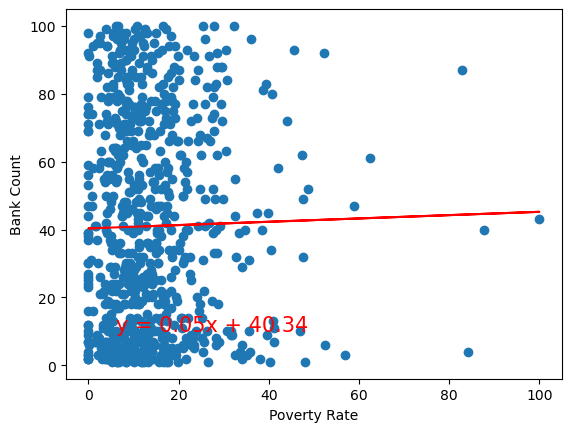

In [13]:
## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = census_data_complete["Poverty Rate"].astype("float")
y_values = census_data_complete["Bank Count"].astype("float")

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Poverty Rate')
plt.ylabel('Bank Count')

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()

## 6. Analysis.

Write a sentence describing your findings. Were they what you expected? What other factors could be at play?

* There is a very weak correlation between poverty rates and bank counts. Keep in mind that linear regression will not consider other factors such as population or size of the city.